<a href="https://colab.research.google.com/github/MJ-best/-DACON-AI-/blob/main/%5Bfull_version%5Dminjun_plasma_diagnosis_with_ML_20230225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electrical Diagnosis for Dielectric Barrier Discharge(DBD) using Measurement Data driven Machine Learning Technique

- e-mail : minjoun@gmail.com
- SPDX-FileCopyrightText: © 2022 KIM MINJUN  minjoun@gmail.com
- SPDX-License-Identifier: BSD-3-Clause

BSD 3-Clause License

Copyright © 2022 KIM MINJUN minjoun@gmail.com

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

● Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

● Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

● Neither the name of the KIM MINJUN nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [48]:
import datetime
from pytz import timezone

print("last update : ",datetime.datetime.now(timezone('Asia/Seoul')))

last update :  2023-02-25 15:39:36.356444+09:00


#개발목적
- 오실로스코프로 측정한 대기압 surface DBD 플라즈마 방전의 전기적 측정데이터(시간에 따른 전압과 전류의 변화)를 이용해 플라즈마의 상태를 이해하는데 필요한 변수인 전자밀도, 방전전압, Power, 전하량, 방전횟수, 커패시턴스 등을 계산합니다.
- surface DBD는 방전이 발생할때 표면유전체와 발생하는 플라즈마의 물리화학적 상호작용으로 인해 표면에 열화가 발생하게 됩니다. 이로 인해 플라즈마의 상태가 변화하게 되는데, 머신러닝을 이용해 열화가 생기는 시점을 계산하고 예측하는 것이 목표입니다.

In [49]:
import io
import os
import numpy as np
import pandas as pd
import math
from scipy import optimize
from scipy.signal import find_peaks, peak_prominences, chirp, peak_widths
import matplotlib.pyplot as plt

# 데이터 분석을 위한 측정 데이터 준비
- CSV 파일을 직접 업로드 or 구글 드라이브에 연결해서 구글 드라이브 파일 경로 이용
- 측정데이터가 들어있는 폴더명을 입력하면 폴더 내부의 CSV파일을 자동으로 읽어온다
- 동일 조건으로 측정한 데이터를 한 폴더안에 넣어야 한다 (불러온 데이터를 한번에 계산하기 때문)

In [50]:
#실험조건 입력 
gas = "air"
pressure = 1.013 # 1.013 bar (1 atm) 
distance = 100E-6 # 100um 

In [51]:
#구글 드라이브에서 파일을 업로드
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [52]:
path = '/content/drive/MyDrive/*Plasma Code/plasma_data/m3_data/20200720 M3 15시간/ALL0001.CSV'

In [53]:
#불러온 CSV 파일 확인
info = pd.read_csv(path, encoding='utf-8-sig', error_bad_lines=False).reset_index()
info.columns = ["V_Time" , "Voltage", "C_Time", "Current", "None"]
del info["None"]
info.head(20)

,V_Time,Voltage,C_Time,Current
0,Memory Length,5000,Memory Length,5000
1,Trigger Level,75.2mA,Trigger Level,75.2mA
2,Source,CH1,Source,CH2
3,Label,,Label,
4,Probe Ratio,1.000E+03,Probe Ratio,2.000E+00
5,Vertical Units,V,Vertical Units,A
6,Vertical Scale,1.000E+03,Vertical Scale,4.000E-02
7,Vertical Position,1.600E+02,Vertical Position,0.000E+00
8,Horizontal Units,S,Horizontal Units,S
9,Horizontal Scale,5.000E-06,Horizontal Scale,5.000E-06


In [54]:
# 측정데이터 정보 라벨링
# Bring Date from oscilloscope
Date = pd.to_datetime(info["Voltage"][14])
# Bring Sampling Period from oscilloscope
Sampling_Period = float(info["Voltage"][12])
# Calculating experimental Sampling Period by substracting two measured time infomations 
dt = float(info["V_Time"][18]) - float(info["V_Time"][17])
# Bring Voltage Probe's Ratio and Current Probe's Infomation
V_Probe_Ratio = float(info["Voltage"][4])
C_Probe_Ratio = float(info["Current"][4])

print("<Date>", Date , "<Sampling Period>", Sampling_Period, "<Real Sampling Period>",dt,"<Voltage Probe Ratio>",V_Probe_Ratio,"<Current Probe Ratio>",C_Probe_Ratio,sep='\n')

<Date>
2020-07-20 20:10:22
<Sampling Period>
1e-08
<Real Sampling Period>
9.999999999940612e-09
<Voltage Probe Ratio>
1000.0
<Current Probe Ratio>
2.0


# 데이터 전처리 : 측정데이터를 이용한 물리량 계산
##전류전압 측정데이터를 이용한 물리량 계산 알고리즘
- 계산을 빠르게 하기 위해 넘파이의 어레이배열을 이용한다.
- 소숫점 계산을 부동소숫점으로 할 경우 생기는 프로그램상의 오류를 줄이기 위해 고정소숫점을 이용한다
- 측정데이터를 봤을때 데이터가 소수점 6자리까지 표현된다, numpy의 round함수를 이용해서 소숫점 6자리에서 반올림해 고정소숫점을 만들어준다

In [55]:
IV = info[['Voltage', 'Current']].copy()
IV = IV.drop(list(range(0,17)))
IV = IV.reset_index(drop = True)
IV = IV.astype('float')

I = IV['Current'].to_numpy()
I = np.round(I, 6)
V = IV['Voltage'].to_numpy()
V = np.round(V,1)

## 한주기의 데이터를 찾는방법 : Sinusoidal한 주기데이터의 경우
- 측정된 전류전압 데이터를 분석을 위해 한 주기로 나눠준다
- 전압이 0인 지점의 인덱스를 찾는다
- 인덱스리스트를 미분하여 V=0인 인덱스 데이터사이의 거리를 찾는다
- 서로의 거리가 100이상인 인덱스를 찾는다 (측정장비의 노이즈 또는 측정 감도로 인해 V=0인 포인트가 여러개 생길 수 있으므로 0으로 측정되는 거리가 먼 데이터를 찾아낸다)

In [56]:
zero_idx = np.where(V == 0)
diff_zero_idx = np.diff(zero_idx)
zero_point_idx = np.where(diff_zero_idx > 100) 
zero_point_idx = list(zero_point_idx[1])

## 디지털 오실로스코프의 샘플링 정보를 이용해 일그러진 파형에서의 에너지 계산
- DBD 방전의 경우 전압과 전류의 파형은 플라즈마 방전으로 인한 전압강하로 인해 일그러진 파형이 됩니다.
- 디지털 오실로스코프로 측정한 전류전압 데이터는 일정한 sampling rate로 측정되어 있는 불연속적인 데이터입니다.
- 불연속적인 데이터셋과 샘플링 주기를 이용해 연속적인 물리량을 근사할 수 있습니다. 
- see also : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=lecroykorea&logNo=221320591220


## DC offset 제거
- DC 오프셋은 측정장비의 적분회로로 인해 생겨나는 오류입니다.
- 한주기의 데이터의 평균값을 계산하여 DC성분을 제거하는 방법과 FFT를 이용한 필터로 DC성분을 제거하는 방법이 있습니다.
- I_dc를 계산하여 데이터 셋에서 제거하여 측정값을 보정해줍니다
- see : http://blog.originlab.com/how-to-remove-dc-offset-before-performing-fft

In [57]:
for i in range(0,len(zero_idx[0][zero_point_idx])-2):
    
    t1 = zero_idx[0][zero_point_idx][i]
    t2 = zero_idx[0][zero_point_idx][i+2]

    I_dc = np.mean(I[t1:t2]) #Current DC offset

    I_1cyc = I[t1:t2] - I_dc
    I_1cyc = np.round(I_1cyc,6)
    V_1cyc = V[t1:t2]
    V_1cyc = np.round(V_1cyc,6)

    T_1cyc = np.array(list(range(0,len(I_1cyc))))*dt
    T_N = len(I_1cyc)
    Period = len(I_1cyc)*dt
    Freq = 1/Period

    VV = np.zeros(T_N)
    VV_int = [0.0]
    
    VV = np.array([V_1cyc[j] * V_1cyc[j] for j in range(T_N)])
    for j in range(T_N):
        VV_int = VV_int + VV[j]*dt
        
    Vrms = math.sqrt(VV_int/Period)
    
    II = np.zeros(T_N)
    II_int = [0.0]

    II = np.array([I_1cyc[j] * I_1cyc[j] for j in range(T_N)])
    for j in range(T_N):
        II_int = II_int + II[j]*dt
    
    Irms = math.sqrt(II_int/Period)

    Energy_1cyc = np.zeros(T_N)
    Energy_int = [0.0]

    Energy_1cyc = np.array([V_1cyc[j]*I_1cyc[j] for j in range(T_N)])
    for j in range(T_N):
        Energy_int = Energy_int + Energy_1cyc[j]*dt
        
    Energy = Energy_int[0]

    Q_1cyc = np.zeros(T_N)
    Q_int = [0.0]

    for j in range(T_N):
        Q_int = Q_int + I_1cyc[j]*dt
        Q_1cyc[j] = Q_int
  
    Q_1cyc = np.round(Q_1cyc, 12)

In [58]:
print("Period :" ,"%.2e"%Period)
print("Freq :" ,"%.2e"%Freq)
print("Energy :" ,"%.2e"%Energy)
print("Irms :" ,"%.2e"%Irms)
print("Vrms :" ,"%.2e"%Vrms)

Period : 2.16e-05
Freq : 4.63e+04
Energy : 1.47e-04
Irms : 1.71e-02
Vrms : 1.46e+03


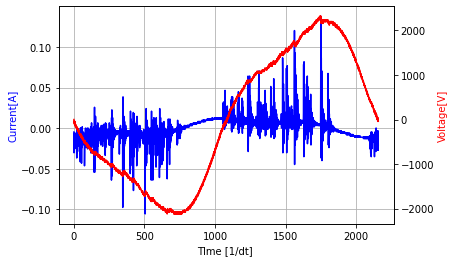

In [59]:
# 전류전압 측정 데이터 시각화
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(I_1cyc, label = 'Current', color = 'b')
ax2.plot(V_1cyc, label = 'Voltage', color = 'r')
ax1.set_xlabel("TIme [1/dt] ")
ax1.set_ylabel("Current[A]", color='b')
ax2.set_ylabel("Voltage[V]",color='r')
ax1.grid()

##Find peaks algorithms : Plasma pulse detection
- DBD는 커패시터구조이기 때문에 측정된 전류그래프에서 생기는 펄스는 플라즈마 방전전류로 인해 생겨난 펄스이다. 따라서 각각의 펄스는 각각의 방전을 의미한다.
- find_peaks 라이브러리는 극대값을 찾는 알고리즘으로 이웃값과의 단순비교로 피크를 찾는 알고리즘을 이용한다. 이때 옵션으로 width를 sampling period x 2 로 설정해 노이즈가 피크로 검출되는것을 방지한다.
- prominences 옵션은 주변의 피크와 구별되기 위해 필요한 옵션으로 상대적인 기준점을 제공해 기준점보다 튼 값의 피크만을 검출되도록 한다. 이는 데이터셋마다 다를 수 있기 때문에 sensitivity 가중치(w:작을수록 민감해짐)를 둬서 조정하도록 했다.
- FWHM으로 pulse의 길이를 계산했다 (rel_height = 0.5)
- IQR 방식을 사용해서 펄스길이가 너무 길거나 너무 짧은 값들은 노이즈 및 잘못계산된 것으로 생각하고 제거한다

In [60]:
def find_peak_and_width(data, w):
  peaks, _ = find_peaks(data, width = 2)
  prominences = peak_prominences(data, peaks)[0]
  constant = w # constant depeond on peak dection sensitivity (1.001 ~ 10) 
  prominence_new = np.percentile(prominences, [0, 25, 50, 75, 100], interpolation='nearest')[2]*constant
  new_peaks, _ = find_peaks(data, prominence = prominence_new)
  new_prominences = peak_prominences(data, new_peaks)[0]
  new_widths = peak_widths(data, new_peaks, rel_height = 0.5)

  def find_outlier(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5) # Q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5) # Q3 + (iqr * 1.5)
    outlier = np.where((data > upper_bound) | (data < lower_bound)) # 최대값보다 크고, 최소값보다 작은 데이터의 인덱스 추출
    return outlier

  final_peaks = np.delete(new_peaks, find_outlier(new_widths[0]))
  final_widths = peak_widths(data, final_peaks, rel_height = 0.5) # rel_height = 0.5 is same definition in MATLAB
  return final_peaks, final_widths[0]

## FFT분석으로 discharge 전류와 displacement 전류 구분
- FFT를 구현해보았다.
- 출처 : https://lifelong-education-dr-kim.tistory.com/4

/usr/local/lib/python3.8/dist-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in true_divide
  val = 1.0 / (n * d)
/usr/local/lib/python3.8/dist-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


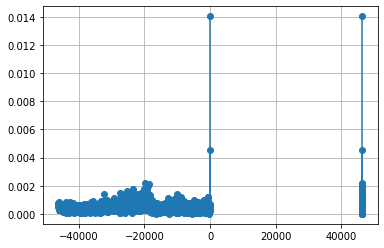

In [61]:
s_fft = np.fft.fft(I_1cyc) # 추후 IFFT를 위해 abs를 취하지 않은 값을 저장한다.
amplitude = abs(s_fft)*(2/len(s_fft)) # 2/len(s)을 곱해줘서 원래의 amp를 구한다.
frequency = np.fft.fftfreq(len(s_fft), T_1cyc)

plt.stem(frequency, amplitude)
plt.grid(True)
plt.show()

In [62]:
fft_freq = frequency.copy()
peak_index = amplitude[:int(len(amplitude)/2)].argsort()[-1]
peak_freq = fft_freq[peak_index]

In [63]:
fft_1x = s_fft.copy()
fft_1x[fft_freq!=peak_freq] = 0
filtered_data = 2*np.fft.ifft(fft_1x)
cycle = round(Freq/peak_freq)

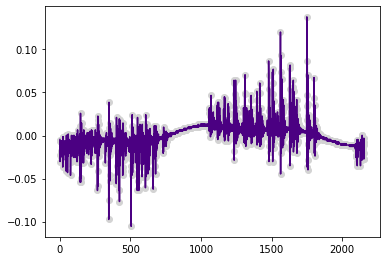

In [64]:
plt.plot(I_1cyc, marker='o', color='lightgrey')
plt.plot(I_1cyc, color='indigo')
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
plt.show()

## 전류신호에서의 펄스의 의미
- 전류펄스는 플라즈마가 발생했다는 것을 의미한다.
- 전류펄스가 발생한 시점을 기준으로 플라즈마가 생기는 전압구간과 DBD의 self current limit로 인한 플라즈마가 꺼지는 전압구간으로 인덱스를 나눠서 플라즈마의 물리값을 계산한다
- 플라즈마가 발생하는 구간 T0-T1, T2-T3
- 플라즈마가 발생하지 않는 구간 T1-T2, T3-T4
- sig_sine : 파형이 사인파인지 역사인파인지를 알수있는 변수
- sig_sine = True 이면 T0-T1은 positive discharge구간이고 T2-T3는 negative discharge 구간이 된다
- sig_sine = False 이면 T0-T1은 negative discharge 구간이고 T2-T3는 positive discharge 구간이 된다

**2022년 11월 28일 개선사항 적용**
- I_1cyc과 V_1cyc을 곱해서 VI 도메인에서 피크를 찾았습니다.
- 플라즈마 방전으로 인해 생기는 에너지의 변화를 기준으로 피크를 찾았기 때문에 물리적으로 해석가능합니다.


**문제점 발견**
- 방전이 일찍 끝나는 경우에 Vmax가 너무 작게 잡힘
- 해결 아이디어 : np.max(V) > V[T1] 면 T1 = np.argmax(V) 로 하고 아니면 T1 그대로 가도록


In [65]:
#플라즈마 방전구간 설정
#방전구간 T0-T1, T2-T3

IV_1cyc = I_1cyc * V_1cyc
peaks, widths = find_peak_and_width(IV_1cyc, 1.5)
diff_peak_idx = np.diff(peaks)
plasma_off_idx = np.argmax(diff_peak_idx)
off_idx = plasma_off_idx.tolist()

T0 = peaks[0]
T1 = peaks[off_idx]
T2 = peaks[np.argmax(diff_peak_idx)+1]
T3 = peaks[-1]
T4 = len(V_1cyc)

# V의 파형이 싸인인지 역싸인인지를 구분한다.

if np.argmin(V_1cyc) > np.argmax(V_1cyc):
#sine 
  sig_sine = True
else: 
#-sine
  sig_sine = False 

<ipython-input-60-477f93a754a1>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  prominence_new = np.percentile(prominences, [0, 25, 50, 75, 100], interpolation='nearest')[2]*constant


In [66]:
#방전이 Vmax 시점 보다 빨리 끝나는 경우 T1과 T3 시점을 수정해야한다 (파형도고려!)
if sig_sine == True:
    if V_1cyc[T1] >= np.max(V_1cyc):
      T1 = T1
    else:
      T1 = np.argmax(V_1cyc)
else:
    if V_1cyc[T1] <= np.min(V_1cyc):
      T1 = T1
    else:
      T1 = np.argmin(V_1cyc)

if sig_sine == True:
    if V_1cyc[T3] <= np.min(V_1cyc):
      T3 = T3
    else:
      T3 = np.argmin(V_1cyc)
else:
    if V_1cyc[T3] >= np.max(V_1cyc):
      T3 = T3
    else:
      T3 = np.argmax(V_1cyc)

Vmin_1 = np.max(V_1cyc[peaks][V_1cyc[peaks]<0])
Vmin_2 = np.min(V_1cyc[peaks][V_1cyc[peaks]>0])
Vmax_1 = V_1cyc[T1]
Vmax_2 = V_1cyc[T3]

In [67]:
#전류신호를 주기에 맞추어 모두 양으로 inverse 시킨 전류신호를 만들었다.
#이 전류신호를 이용해서 피크를 찾으면 조금 더 정확한 duration 값 등을 얻을 수 있지 않을까 기대한다.
#절대값을 취하면 전류신호가 +-로 진동하는 걸 모두 +로 바꿔줘서 pulse갯수가 많게 계산되고 왜곡이 생기게 된다
if sig_sine :
    I_1 = np.array(-I_1cyc[T2:T4])
    I_2 = np.delete(I_1cyc, range(T2,T4))
    I_3 = np.insert(I_2, T2, I_1)
    I_1cyc_inv = I_3
else:
    I_1 = np.array(-I_1cyc[T0:T2])
    I_2 = np.delete(I_1cyc, range(T0,T2))
    I_3 = np.insert(I_2, T0, I_1)
    I_1cyc_inv = I_3

#마찬가지로 전압신호도 모두 양의 값으로 inverse 시켰다.
if sig_sine :
    V_1 = np.array(-V_1cyc[T2:T4])
    V_2 = np.delete(V_1cyc, range(T2,T4))
    V_3 = np.insert(V_2, T2, V_1)
    V_1cyc_inv = V_3
else:
    V_1 = np.array(-V_1cyc[T0:T2])
    V_2 = np.delete(V_1cyc, range(T0,T2))
    V_3 = np.insert(V_2, T0, V_1)
    V_1cyc_inv = V_3

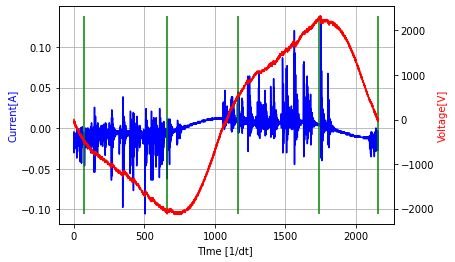

In [68]:
# 플라즈마 방전구간 설정
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(I_1cyc, label = 'Current', color = 'b')

ax1.vlines([T0,T1,T2,T3,T4], np.min(I_1cyc), np.max(I_1cyc), color = 'g')
ax2.plot(V_1cyc, label = 'Voltage', color = 'r')
ax1.set_xlabel("TIme [1/dt] ")
ax1.set_ylabel("Current[A]", color='b')
ax2.set_ylabel("Voltage[V]",color='r')
ax1.grid()

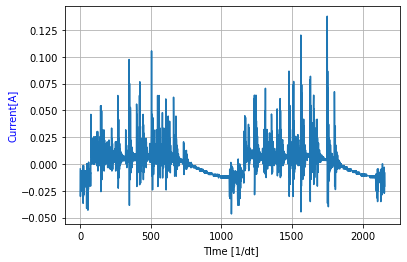

In [69]:
#절대값이 아닌 반주기를 기준으로 inverse해서 +/-로 진동하는 신호도 그대로 계산할 수 있다
plt.plot(I_1cyc_inv)
plt.xlabel("TIme [1/dt] ")
plt.ylabel("Current[A]", color='b')
plt.grid()

## Non-Dishcarge QV  Linear  Regression으로 Displacement Charge 찾아내기
2023/02/25
- 방전구간 : T0-T1, T2-T3
- 방전이 없는 구간 : T1-T2, T3-T4
- 방전이 없는 구간의 QV를 Linear Regression으로 학습
- 방전이 있는 구간의 V를 넣어서 Displacement Q값을 예측
- 방전이 있는 구간에서 측정된 Q에서 Displacement Q를 빼주면 Discharge Q를 계산할 수 있다

In [138]:
from  sklearn.linear_model import LinearRegression
# X값이 되어줄 T1-T2 시간에서의 V
# y값이 되어줄 T1-T2 시간에서의 Q
V_time_in_T1_T2 = V_1cyc[T1:T2].reshape(-1,1)
Q_time_in_T1_T2 = Q_1cyc[T1:T2].reshape(-1,1)
reg_QV_in_T1_T2 = LinearRegression().fit(V_time_in_T1_T2, Q_time_in_T1_T2)

In [151]:
#예측할 구간 T2-T3
V_time_in_T2_T3 = V_1cyc[T2:T3].reshape(-1,1)
Q_time_in_T2_T3 = Q_1cyc[T2:T3].reshape(-1,1)
displacement_Q_time_in_T2_T3 = reg_QV_in_T1_T2.predict(V_time_in_T2_T3)

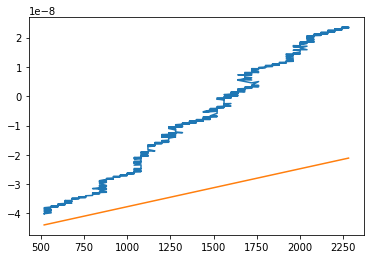

In [162]:
#측정된 Q와 계산한 displacement Q 시각화
plt.plot(V_time_in_T2_T3, Q_time_in_T2_T3, V_time_in_T2_T3, displacement_Q_time_in_T2_T3)

In [202]:
#discharge Q 계산
discharge_Q_time_in_T2_T3 = Q_time_in_T2_T3 - displacement_Q_time_in_T2_T3

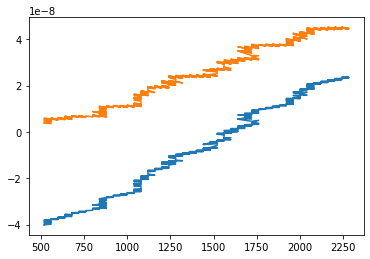

In [203]:
#Q와 discharge Q 시각화
plt.plot(V_time_in_T2_T3, Q_time_in_T2_T3, V_time_in_T2_T3, discharge_Q_time_in_T2_T3)

In [187]:
# X값이 되어줄 T3-T4 시간에서의 V
# y값이 되어줄 T3-T4 시간에서의 Q
V_time_in_T3_T4 = V_1cyc[T3:T4].reshape(-1,1)
Q_time_in_T3_T4 = Q_1cyc[T3:T4].reshape(-1,1)
reg_QV_in_T3_T4 = LinearRegression().fit(V_time_in_T3_T4, Q_time_in_T3_T4)

In [188]:
#예측할 구간 T0-T1
V_time_in_T0_T1 = V_1cyc[T0:T1].reshape(-1,1)
Q_time_in_T0_T1 = Q_1cyc[T0:T1].reshape(-1,1)
displacement_Q_time_in_T0_T1 = reg_QV_in_T3_T4.predict(V_time_in_T0_T1)

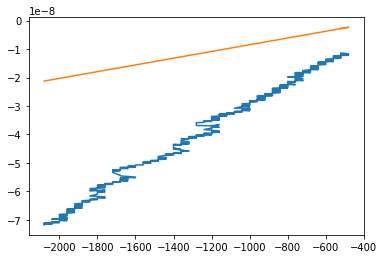

In [189]:
#측정된 Q와 계산한 displacement Q 시각화
plt.plot(V_time_in_T0_T1, Q_time_in_T0_T1, V_time_in_T0_T1, displacement_Q_time_in_T0_T1)

In [196]:
#discharge Q 계산
discharge_Q_time_in_T0_T1 = Q_time_in_T0_T1 - displacement_Q_time_in_T0_T1

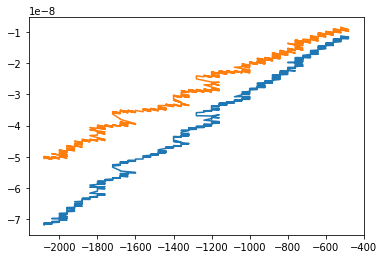

In [197]:
#Q와 discharge Q 시각화
plt.plot(V_time_in_T0_T1, Q_time_in_T0_T1, V_time_in_T0_T1, discharge_Q_time_in_T0_T1)

## discharge Q를 미분해 discharge current 계산
2023/02/25

In [238]:
discharge_I_time_in_T2_T3 = np.diff(discharge_Q_time_in_T2_T3.reshape(1,-1)[0])

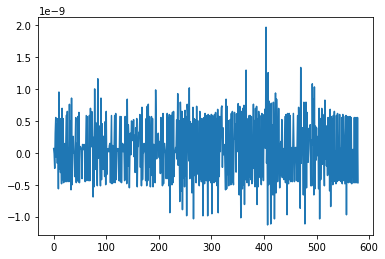

In [242]:
plt.plot(discharge_I_time_in_T2_T3)

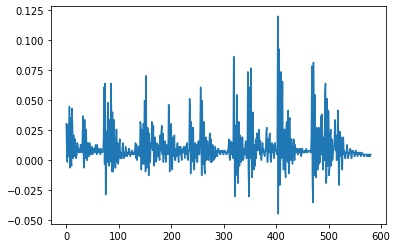

In [243]:
plt.plot( I_1cyc[T2:T3])

- 이미 적분이 들어간 Q에서 뺄셈이 들어가게 되니까 이걸 미분했을때 노이즈가 너무 많아짐(적분상수가 영향을 미쳤을 것)
- 아예 미분한 I값을 빼주자

In [251]:
new_displacement_I_time_in_T2_T3 = np.diff(displacement_Q_time_in_T2_T3.reshape(1,-1)[0])

In [252]:
new_discharge_I_time_in_T2_T3 = I_1cyc[T2:T3-1] - new_displacement_I_time_in_T2_T3

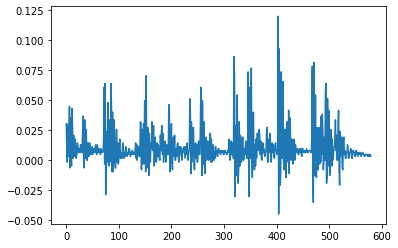

In [253]:
plt.plot(new_discharge_I_time_in_T2_T3)

##제안사항 (2022년 11월 28일)
- 피크를 찾을때의 기준을 IV 도메인에서 찾으면 어떨까?
- I는 너무 값이 작아서 노이즈랑 구별이 안되고
- V는 전압강하로 인해 파형이 찌그러진다
- IV 도메인에서 피크를 찾고 I에 쒸워보는건 어떨까?

In [70]:
#T0:T1 첫 반주기에서의 방전구간 내의 피크갯수를 계산
first_period_I_cyc_inv= I_1cyc_inv[T0:T1]
first_period_peaks, first_period_widths = find_peak_and_width(first_period_I_cyc_inv, 2)

'''
#T0:T1 첫 반주기에서의 방전구간 내의 피크갯수를 계산 (VI 도메인에서 계산)
first_period_IV_cyc= IV_1cyc[T0:T1]
first_period_peaks, first_period_widths = find_peak_and_width(first_period_IV_cyc, 2)
'''

<ipython-input-60-477f93a754a1>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  prominence_new = np.percentile(prominences, [0, 25, 50, 75, 100], interpolation='nearest')[2]*constant


'\n#T0:T1 첫 반주기에서의 방전구간 내의 피크갯수를 계산 (VI 도메인에서 계산)\nfirst_period_IV_cyc= IV_1cyc[T0:T1]\nfirst_period_peaks, first_period_widths = find_peak_and_width(first_period_IV_cyc, 2)\n'

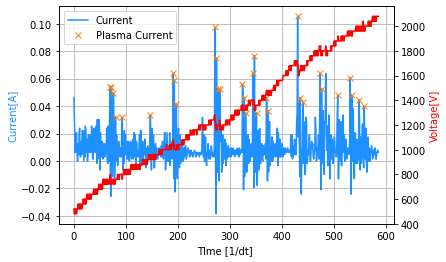

In [71]:
# 찾은 피크값 시각화 T0 - T1 구간
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(first_period_I_cyc_inv, label = 'Current', color = 'dodgerblue')
ax1.plot(first_period_peaks, first_period_I_cyc_inv[first_period_peaks], "x", label = 'Plasma Current', color = '#ff7f0e')
ax2.plot(V_1cyc_inv[T0:T1], label = 'Voltage', color = 'r')
ax1.set_xlabel("TIme [1/dt] ")
ax1.set_ylabel("Current[A]", color='dodgerblue')
ax2.set_ylabel("Voltage[V]",color='r')
ax1.legend()
ax1.grid()

In [72]:
#number of dischrages per period
first_period_num_discharges = len(first_period_peaks)

#each current pulse duration data
first_period_pulse_duration = first_period_widths*dt
first_period_pulse_duration_mean = np.mean(first_period_pulse_duration)
first_period_pulse_duration_std = np.std(first_period_pulse_duration)

#each current pulse energy data
first_period_peak_energy = first_period_widths*dt*I_1cyc_inv[first_period_peaks]*V_1cyc_inv[first_period_peaks]
first_period_peak_energy_mean = np.mean(first_period_peak_energy)
first_period_peak_energy_std = np.std(first_period_peak_energy)

print("number of discharges on first half period(count) : ", first_period_num_discharges)
print("average pulse duration on first half period(sec) : ", "%.2e"%first_period_pulse_duration_mean)
print("average plasma peak energy on first half period(J) : ", "%.2e"%first_period_peak_energy_mean)

number of discharges on first half period(count) :  31
average pulse duration on first half period(sec) :  1.54e-08
average plasma peak energy on first half period(J) :  2.63e-07


In [73]:
#T2:T3 반주기에서의 피크갯수를 계산
second_period_I_cyc_inv= I_1cyc_inv[T2:T3]
second_period_peaks, second_period_widths = find_peak_and_width(second_period_I_cyc_inv,2)

'''
#T2:T3 반주기에서의 피크갯수를 계산(IV도메인에서)
second_period_IV_cyc= IV_1cyc[T2:T3]
second_period_peaks, second_period_widths = find_peak_and_width(second_period_IV_cyc,2)
'''

<ipython-input-60-477f93a754a1>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  prominence_new = np.percentile(prominences, [0, 25, 50, 75, 100], interpolation='nearest')[2]*constant


'\n#T2:T3 반주기에서의 피크갯수를 계산(IV도메인에서)\nsecond_period_IV_cyc= IV_1cyc[T2:T3]\nsecond_period_peaks, second_period_widths = find_peak_and_width(second_period_IV_cyc,2)\n'

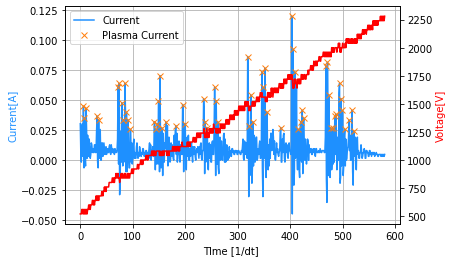

In [74]:
# 찾은 피크값 시각화 T2 - T3 구간
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(second_period_I_cyc_inv, label = 'Current', color = 'dodgerblue')
ax1.plot(second_period_peaks, second_period_I_cyc_inv[second_period_peaks], "x", label = 'Plasma Current', color = '#ff7f0e')
ax2.plot(V_1cyc_inv[T2:T3], label = 'Voltage', color = 'r')
ax1.set_xlabel("TIme [1/dt] ")
ax1.set_ylabel("Current[A]", color='dodgerblue')
ax2.set_ylabel("Voltage[V]",color='r')
ax1.legend()
ax1.grid()

In [75]:
#number of dischrages per period
second_period_num_discharges = len(second_period_peaks)

#each current pulse duration data
second_period_pulse_duration = second_period_widths*dt
second_period_pulse_duration_mean = np.mean(second_period_pulse_duration)
second_period_pulse_duration_std = np.std(second_period_pulse_duration)

#each current pulse energy data
second_period_peak_energy = second_period_widths*dt*I_1cyc_inv[second_period_peaks]*V_1cyc_inv[second_period_peaks]
second_period_peak_energy_mean = np.mean(second_period_peak_energy)
second_period_peak_energy_std = np.std(second_period_peak_energy)

print("number of discharges on second half period(count) : ", second_period_num_discharges)
print("average pulse duration on second half period(sec) : ", "%.2e"%second_period_pulse_duration_mean)
print("average plasma peak energy on second half period(J) : ", "%.2e"%second_period_peak_energy_mean)

number of discharges on second half period(count) :  60
average pulse duration on second half period(sec) :  1.55e-08
average plasma peak energy on second half period(J) :  3.10e-07


## Practical Method for Calculating Capacitance
- Since Manley's paper, many researchers refer that DBD's capacitance altered during gas discharge because gas gap capacitance disapear
- In the QV Lissajous Graph, researchers point out the each side edge of the parallelogram are gas gap breakdown voltage(firing voltage)
- Fitting the QV Lissajous graph with four lines to make parallelogram and figure out the side edge point
- Manley의 방법은 방전이 전극의 전체영역에서 일어난다고 가정하는 모델이었다. 방전면적을 고려한 Peeters의 회로모델을 이용해 피팅에 적용을 할 수 있겠다.


## Variables
- C_diel_1 : DBD actuator's effective dielectric capacitance
- C_diel_2 : DBD actuator's effective dielectric capacitance
- C_gas_1 : effective gas gap capacitance
- C_gas_2 : effective gas gap capacitance
- C_total_1 : no plasma status effective total capacitance 
- C_total_2 : no plasma status effective total capacitance
- $ \frac {1}{C_{total}} = \frac {1}{C_{diel}} + \frac {1}{C_{gas}}$
- $\zeta$_diel_1 : 리사주 그래프에서의 방전영역 기울기
- $\zeta$diel_2 : 리사주 그래프에서의 방전영역 기울기
- 방전이 일어나는 영역인자 α
- 방전이 일어나지 않는 영역인자 β 
- $ α + β = 1 $
- $ α = \frac{C_{diel}-ζ_{diel}}{C_{diel}-C_{total}} $
- $ β = \frac{ζ_{diel}- C_{total}}{C_{diel}-C_{total}}$
- $ ζ_{diel} = αC_{total} + βC_{diel}$
- $ Q_{max} = \zeta_{diel}ΔV $
- $ ΔQ_{dis} = \frac{1- \frac{C_{total}}{ζ_{diel}}}{1- \frac{C_{total}}{C_{diel}}}Q_{max}$

## Capacitance fitting
- fitting 알고리즘은 $y = ax + b$ 의 선형모델을 이용해 최소제곱법을 이용한다

In [76]:
def linear_fit(x, a, b):
  return a*x+b

#T0:T1 plasma on : dielectric capacitance
popt0, pcov0 = optimize.curve_fit(linear_fit, V_1cyc[T0:T1], Q_1cyc[T0:T1])
Zdiel_1 = popt0[0]
Zdiel_1_error = np.sqrt(np.diag(pcov0))[0]
#T1:T2 plasma off : dielectric + air gap capacitance
popt1, pcov1 = optimize.curve_fit(linear_fit, V_1cyc[T1:T2], Q_1cyc[T1:T2])
Ctot_1 = popt1[0]
Ctot_1_error = np.sqrt(np.diag(pcov1))[0]
#T2:T3 plasma on : dielectric capacitance
popt2, pcov2 = optimize.curve_fit(linear_fit, V_1cyc[T2:T3], Q_1cyc[T2:T3])
Zdiel_2 = popt2[0]
Zdiel_2_error = np.sqrt(np.diag(pcov2))[0]
#T3:T4 plasma off : dielectric + air gap capacitance
popt3, pcov3 = optimize.curve_fit(linear_fit, V_1cyc[T3:T4], Q_1cyc[T3:T4])
Ctot_2 = popt3[0]
Ctot_2_error = np.sqrt(np.diag(pcov3))[0]


#방전영역을 아무리 정확하게 구한다고 해도 계산의 요동이 생김
discharge_time_list_1 = list(range(T0,T1))
discharge_time_list_2 = list(range(T2,T3))

Q_int_1 = [0.0]
Qt_1 = np.zeros(discharge_time_list_1[-1])
for j in discharge_time_list_1:
    Q_int_1 = Q_int_1 + I_1cyc_inv[j-1]*dt
    Qt_1[j-1] = Q_int_1

Q_int_2 = [0.0]
Qt_2 = np.zeros(discharge_time_list_2[-1])
for k in discharge_time_list_2:
    Q_int_2 = Q_int_2 + I_1cyc_inv[k-1]*dt
    Qt_2[k-1] = Q_int_2

Q_transfer_1 = np.delete(Qt_1, np.where(Qt_1 == 0.0))
Qmax_1 = Q_transfer_1[-1]
Q_transfer_2 = np.delete(Qt_2, np.where(Qt_2 == 0.0))
Qmax_2 = Q_transfer_2[-1]
'''
#Qmax = Zdiel * del V 식으로 계산
Qmax_1 = Zdiel_1* abs(Vmax_1 - Vmin_1)
Qmax_2 = Zdiel_2* abs(Vmax_2 - Vmin_2)
'''
delta_Q1 =abs(np.max(Q_1cyc[first_period_peaks])-np.min(Q_1cyc[first_period_peaks]))
delta_Q2 =abs(np.max(Q_1cyc[second_period_peaks])-np.min(Q_1cyc[second_period_peaks]))

Cdiel_1 = abs(Ctot_1 / (1-(Qmax_1 / delta_Q1)+((Ctot_1/Zdiel_1)*(Qmax_1/delta_Q1))))
Cdiel_2 = abs(Ctot_2 / (1-(Qmax_2 / delta_Q2)+((Ctot_2/Zdiel_2)*(Qmax_2/delta_Q2))))

#1/Ctot = 1/Cdiel + 1/Cgas
Cgas_1 = (Cdiel_1 * Ctot_1)/(Cdiel_1 - Ctot_1)
Cgas_2 = (Cdiel_2 * Ctot_2)/(Cdiel_2 - Ctot_2)

# Using Capacitance calcuate energy by Modified Manlay Method
Power_manely_1 = 4*Cdiel_1*Vmin_1*(Vmax_1-Vmin_1)/(1+Cgas_1/Cdiel_1)
Power_manely_2 = 4*Cdiel_2*Vmin_2*(Vmax_2-Vmin_2)/(1+Cgas_2/Cdiel_2)

#Power factor
#Manley의 방법에 의해 계산된 값은 일 즉 Power [W] 이고 전류와 전압의 곱을 시간으로 나눠계산한 Energy [VA]는 피상전력이므로 이 둘을 이용해 power factor를 계산할 수 있다.
power_factor_1 = Power_manely_1 / Energy
power_factor_2 = Power_manely_2 / Energy

#R Valdiva Barrientos의 경험식 V break down voltage
Vbd_1 = (1.4*(Cdiel_1/Cgas_1)**2)/ np.log(Freq)
Vbd_2 = (1.4*(Cdiel_2/Cgas_2)**2)/ np.log(Freq)

### Displacement Currnet를 없애보자
- T1 : T2 (non plasma)의 Q와 V 데이터를 sklearn의 linear regression으로 학습한다
- T2 : T3 (plasma)의 V의 데이터만 가지고 displacement Q(T2:T3)를 예측한다
- T2 : T3 에서의 Q(discharge + displacement)에서 displacement Q를 제거한다
- 계산한 discharge Q를 미분하여 전류로 치환한다

In [77]:
import sklearn

In [78]:
print("Zdiel_1 : ", "%.2e"%Zdiel_1)
print("Zdiel_2 : ", "%.2e"%Zdiel_2)
print("Cdiel_1 : ", "%.2e"%Cdiel_1)
print("Cdiel_2 : ", "%.2e"%Cdiel_2)
print("Ctot_1 : ",  "%.2e"%Ctot_1)
print("Ctot_2 : ",  "%.2e"%Ctot_2)
print("Cgas_1 : ",  "%.2e"%Cgas_1)
print("Cgas_2 : ",  "%.2e"%Cgas_2)
print("delta Q_1  :", "%.2e"%delta_Q1)
print("delta Q_2  :", "%.2e"%delta_Q2)
print("Qmax_1  :", "%.2e"%Qmax_1)
print("Qmax_2  :", "%.2e"%Qmax_2)
print("Vbd_1 :" "%.2f"%Vbd_1)
print("Vbd_2 :" "%.2f"%Vbd_2)
print("Vmin_1(firing voltage) : ", "%.2f"%Vmin_1)
print("Vmin_2(firing voltage) : ", "%.2f"%Vmin_2)

Zdiel_1 :  3.87e-11
Zdiel_2 :  3.96e-11
Cdiel_1 :  6.39e-11
Cdiel_2 :  6.12e-11
Ctot_1 :  1.30e-11
Ctot_2 :  1.18e-11
Cgas_1 :  1.63e-11
Cgas_2 :  1.47e-11
delta Q_1  : 5.07e-08
delta Q_2  : 5.55e-08
Qmax_1  : 6.07e-08
Qmax_2  : 6.38e-08
Vbd_1 :2.01
Vbd_2 :2.27
Vmin_1(firing voltage) :  -520.00
Vmin_2(firing voltage) :  520.00


In [79]:
#Cg와 d를 이용하면 전극의 면적을 계산할 수 있다
#공기의 epi = 1 이므로
Area_1 = Cgas_1 * distance
Area_2 = Cgas_2 * distance
print('전극면적(m^2) : ',Area_1, Area_2)
Cdiel_1_eff = Cdiel_1 / Area_1
Cdiel_2_eff = Cdiel_2 / Area_2
Cgas_1_eff = Cgas_1 / Area_1
Cgas_2_eff = Cgas_2 / Area_2
Ctot_1_eff = Ctot_1 / Area_1
Ctot_2_eff = Ctot_2 / Area_2
print('단위면적당 커패시턴스 Cd : ',Cdiel_1_eff, Cdiel_2_eff)

전극면적(m^2) :  1.62508102403954e-15 1.465080229353373e-15
단위면적당 커패시턴스 Cd :  39298.72674160973 41753.652380391366


In [80]:
#하나의 펄스가 커패시턴스의 충방전과 같이 생각한다면 2RCd를 이용해서 플라즈마 저항값을 계산할 수 있다
plasma_resistance_1 = first_period_pulse_duration / (2*Cdiel_1)
plasma_resistance_2 = second_period_pulse_duration / (2*Cdiel_2)
plasma_resistance_1_mean = np.mean(plasma_resistance_1)
plasma_resistance_1_std = np.std(plasma_resistance_1)
plasma_resistance_2_mean = np.mean(plasma_resistance_2)
plasma_resistance_2_std = np.std(plasma_resistance_2)
print('플라즈마 저항값 : ',plasma_resistance_1_mean, plasma_resistance_2_mean)

플라즈마 저항값 :  120.31709464661559 126.66769769515221


In [81]:
#플의즈마의 발생과 소멸이 한주기에 두번 일어난다. 따라서 커패시턴스도 에너지도 두번 계산된다
print("Dissipated Power using manely method_1(W) : ",  "%.2e"%Power_manely_1)
print("Power factor_1 : ",  "%.2e"%power_factor_1)
print("Dissipated Power using manely method_2(W) : ",  "%.2e"%Power_manely_2)
print("Power factor_2 : ",  "%.2e"%power_factor_2)

Dissipated Power using manely method_1(W) :  1.69e-04
Power factor_1 :  1.16e+00
Dissipated Power using manely method_2(W) :  1.85e-04
Power factor_2 :  1.26e+00


In [82]:
#방전영역 beta 계수와 비방전영역 alpha 계수 [%]
a1 = (Cdiel_1 - Zdiel_1)/(Cdiel_1 - Ctot_1)*100
a2 = (Cdiel_2 - Zdiel_2)/(Cdiel_2 - Ctot_2)*100
b1 = (Zdiel_1 - Ctot_1)/(Cdiel_1 - Ctot_1)*100
b2 = (Zdiel_2 - Ctot_2)/(Cdiel_2 - Ctot_2)*100

In [83]:
print("first half period non-discharge Area fraction : ", "%.1f"%a1 + "%")
print("first half period discharge Area fraction : ", "%.1f"%b1+"%")
print("second half period non-discharge Area fraction : ", "%.1f"%a2+"%")
print("second half period discharge Area fraction : ", "%.1f"%b2+"%")

first half period non-discharge Area fraction :  49.3%
first half period discharge Area fraction :  50.7%
second half period non-discharge Area fraction :  43.6%
second half period discharge Area fraction :  56.4%


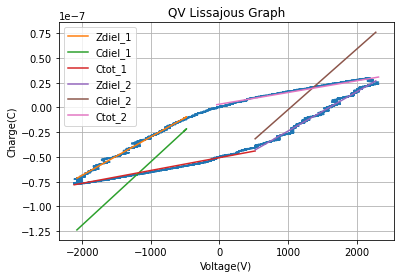

In [84]:
#QV Lissagious curve iinear Regression 시각화
fig, ax = plt.subplots()
plt.plot(V_1cyc, Q_1cyc)
plt.plot(V_1cyc[T0:T1], linear_fit(V_1cyc[T0:T1],popt0[0],popt0[1]), label='Zdiel_1')
plt.plot(V_1cyc[T0:T1], linear_fit(V_1cyc[T0:T1],Cdiel_1,popt0[1]), label='Cdiel_1')
plt.plot(V_1cyc[T1:T2], linear_fit(V_1cyc[T1:T2],popt1[0],popt1[1]), label='Ctot_1')
plt.plot(V_1cyc[T2:T3], linear_fit(V_1cyc[T2:T3],popt2[0],popt2[1]), label='Zdiel_2')
plt.plot(V_1cyc[T2:T3], linear_fit(V_1cyc[T2:T3],Cdiel_2,popt2[1]), label='Cdiel_2')
plt.plot(V_1cyc[T3:T4], linear_fit(V_1cyc[T3:T4],popt3[0],popt3[1]), label='Ctot_2')

ax.set(xlabel='Voltage(V)', ylabel='Charge(C)',
       title='QV Lissajous Graph')
ax.grid()
plt.legend()
plt.show()

## Calculate the electron density
- Approximation : The form of discharge channel to be cylinderical (Morrow R)
- E = V/d
- Filament radious = 0.1 mm effective discharge radius between electrodes A = 0.0001* 0.0001 * pi
- I = J * A 
- $(μ_{e} \times p )_{T_0} = 0.45 \times 10^6 [cm^3̇Torr/Vs]$
- $(μ_{e} \times p )_{T} = T/T_{0}(μ_{e} \times p )_{T_0} [cm^3̇Torr/Vs]$
- T0은 room Temperature, p는 압력
- T는 온도가 달라지는 경우 적용
- 위 공식을 이용해 계산하면 T = T0일때 대기에서 electron mobility ue = 592.12 cm^2 / V s
- discharge peak currnet values used
- peak current density ne 
- ne = J/(E* u_e * e)
- References
- YC Hong : Physics of Plasmas 14, 053503 (2007)
- Morrow R : 1995a Phys. Rev. A 32 1799-1809; 1985b Phys. Rev. 60 714-722
- Y.P.Raizer, Gas Discharge Physics (Springer, New York, 1991)
- K.H.Becker, NON-EQUILIBRIUM AIR PLASMAS AT ATMOSPHERIC PRESSURE (IOP, Bristol and Philadelphia, 2004)
- Robert H Stark (Direct current glow discharges in atmoshpheric air)

In [85]:
# Electon Density Calculation ne(/cm^3) first half period
distance_cm = distance * 100
E = abs(V_1cyc[first_period_peaks])/distance_cm
A = distance_cm * distance_cm * math.pi
J =abs(I_1cyc[first_period_peaks]/A)
electron_mobility = 592.12
electron_charge = 1.602176634e-19
first_period_peak_electron_density = J/(E*electron_mobility*electron_charge)
first_period_peak_electron_density_mean = np.mean(first_period_peak_electron_density)
first_period_peak_electron_density_std = np.std(first_period_peak_electron_density)

# Electon Density Calculation ne(/cm^3) second half period
E = abs(V_1cyc[second_period_peaks])/distance_cm
A = distance_cm * distance_cm * math.pi
J = abs(I_1cyc[second_period_peaks]/A)
electron_mobility = 592.12
electron_charge = 1.602176634e-19
second_period_peak_electron_density = J/(E*electron_mobility*electron_charge)
second_period_peak_electron_density_mean = np.mean(second_period_peak_electron_density)
second_period_peak_electron_density_std = np.std(second_period_peak_electron_density)

#Energy density required to sustain a discharge
Wion = 50 #effective ionization energy in atmospheric air
t_electron = 10E-9 #average lifetime of electron in atmoshperic air 
Psustain1 = first_period_peak_electron_density_mean * Wion / t_electron
Psustain2 = second_period_peak_electron_density_mean*Wion / t_electron

In [86]:
print("first period peak_electron_density_mean(/cm^3) : ", "%.2e"%first_period_peak_electron_density_mean)
print("second period peak_electron_density_mean(/cm^3) : " , "%.2e"%second_period_peak_electron_density_mean)
print("Plasma sustainable energy density in first half period (V/cm^3) : ",  "%.2e"%Psustain1)
print("Plasma sustainable energy density in second half period (V/cm^3) : ",  "%.2e"%Psustain2)

first period peak_electron_density_mean(/cm^3) :  5.31e+12
second period peak_electron_density_mean(/cm^3) :  1.03e+13
Plasma sustainable energy density in first half period (V/cm^3) :  2.66e+22
Plasma sustainable energy density in second half period (V/cm^3) :  5.17e+22


## Calculate the electron temperature
- 아인슈타인 relation을 이용해서 전자온도를 계산하는 방법
- $k_{B}T_{e}/e = D_{e}/μ_{e}$

In [87]:
# De를 계산해야하는데... 어디서 구하냐...

#데이터프레임으로 가공하여 머신러닝 학습데이터셋 생성
- 전류전압 측정데이터에서 계산되는 여러 물리값들은 플라즈마의 발생을 전제로 계산되었지만 물리값들 끼리의 상관관계가 인과관계로 이어지는지는 알 수 없습니다.
- 플라즈마 내에서 일어나는 다양한 물리적 화학적 상호작용이 복잡하게 얽혀있기 때문에 명확한 상관관계를 알아내기는 쉽지 않습니다 (이런 특성 때문에 플라즈마는 일종의 블랙박스로 설명되기도 합니다)
- 지도학습-분류알고리즘을 이용해 여러 물리량 중 어떤 물리량이 표면의 변화에 민감하게 반응하는지 계산해보고, 또 이를 이용해 전압전류 데이터 만으로 표면의 열화정도를 예측합니다.

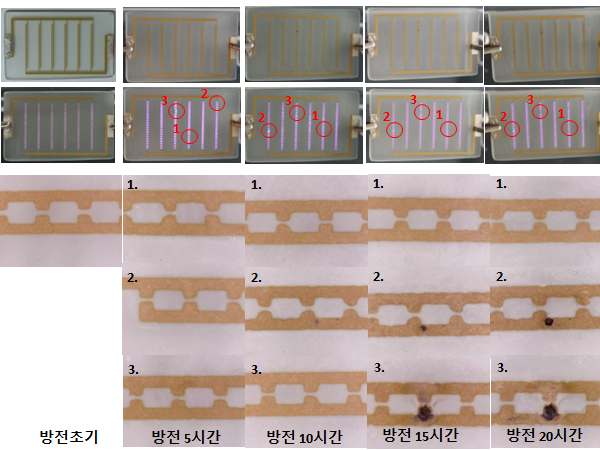

In [88]:
from IPython.display import Image
from urllib import request

url="https://drive.google.com/file/d/1JCawdB_IWE_eoFyNxxvJpCV9jk2d0-rL/view?usp=share_link"
path='https://drive.google.com/uc?export=download&id='+url.split('/')[-2] 

res = request.urlopen(path).read()  
img = Image(res, width='', height='') 
img

In [89]:
#표면의 열화정도를 0, 1, 2로 인덱싱한다
surface_degradtion = 1

#데이터를 데이터프레임으로 가공한다
if sig_sine == True:
  positive_period_num_discharges = first_period_num_discharges
  positive_period_peak_electron_density_mean=first_period_peak_electron_density_mean
  positive_period_peak_electron_density_std=first_period_peak_electron_density_std
  positive_period_peak_energy_mean=first_period_peak_energy_mean
  positive_period_peak_energy_std=first_period_peak_energy_std
  positive_period_pulse_duration_mean=first_period_pulse_duration_mean
  positive_period_pulse_duration_std=first_period_pulse_duration_std
  Zdiel_p = Zdiel_1
  Cdiel_p=Cdiel_1
  Cgas_p=Cgas_1
  Ctot_p=Ctot_1
  positive_period_power_manely = Power_manely_1
  positive_period_power_factor = power_factor_1
  positive_period_plasma_sustain_power=Psustain1
  positive_period_total_transfered_charge = Qmax_1
  positive_period_discharge_transfered_charge = delta_Q1
  Vbd_p = Vbd_1
  Vmin_p = Vmin_1
  positive_period_non_discharge_area = a1
  positive_period_discharge_area = b1

  negative_period_num_discharges = second_period_num_discharges
  negative_period_peak_electron_density_mean=second_period_peak_electron_density_mean
  negative_period_peak_electron_density_std=second_period_peak_electron_density_std
  negative_period_peak_energy_mean=second_period_peak_energy_mean
  negative_period_peak_energy_std=second_period_peak_energy_std
  negative_period_pulse_duration_mean=second_period_pulse_duration_mean
  negative_period_pulse_duration_std=second_period_pulse_duration_std
  Zdiel_n = Zdiel_2
  Cdiel_n=Cdiel_2
  Cgas_n=Cgas_2
  Ctot_n=Ctot_2
  negative_period_power_manely = Power_manely_2
  negative_period_power_factor = power_factor_2
  negative_period_plasma_sustain_power=Psustain2
  negative_period_total_transfered_charge = Qmax_2
  negative_period_discharge_transfered_charge = delta_Q2
  Vbd_n = -Vbd_2
  Vmin_n = Vmin_2
  negative_period_non_discharge_area = a2
  negative_period_discharge_area = b2

else:
  positive_period_num_discharges = second_period_num_discharges
  positive_period_peak_electron_density_mean=second_period_peak_electron_density_mean
  positive_period_peak_electron_density_std=second_period_peak_electron_density_std
  positive_period_peak_energy_mean=second_period_peak_energy_mean
  positive_period_peak_energy_std=second_period_peak_energy_std
  positive_period_pulse_duration_mean=second_period_pulse_duration_mean
  positive_period_pulse_duration_std=second_period_pulse_duration_std
  Zdiel_p = Zdiel_2
  Cdiel_p=Cdiel_2
  Cgas_p=Cgas_2
  Ctot_p=Ctot_2
  positive_period_power_manely = Power_manely_2
  positive_period_power_factor = power_factor_2
  positive_period_plasma_sustain_power=Psustain2
  positive_period_total_transfered_charge = Qmax_2
  positive_period_discharge_transfered_charge = delta_Q2
  Vbd_p = Vbd_2
  Vmin_p = Vmin_2
  positive_period_non_discharge_area = a2
  positive_period_discharge_area = b2

  negative_period_num_discharges = first_period_num_discharges
  negative_period_peak_electron_density_mean=first_period_peak_electron_density_mean
  negative_period_peak_electron_density_std=first_period_peak_electron_density_std
  negative_period_peak_energy_mean=first_period_peak_energy_mean
  negative_period_peak_energy_std=first_period_peak_energy_std
  negative_period_pulse_duration_mean=first_period_pulse_duration_mean
  negative_period_pulse_duration_std=first_period_pulse_duration_std
  Zdiel_n = Zdiel_1
  Cdiel_n=Cdiel_1
  Cgas_n=Cgas_1
  Ctot_n=Ctot_1
  negative_period_power_manely = Power_manely_1
  negative_period_power_factor = power_factor_1
  negative_period_plasma_sustain_power=Psustain1
  negative_period_total_transfered_charge = Qmax_1
  negative_period_discharge_transfered_charge = delta_Q1
  Vbd_n = -Vbd_1
  Vmin_n = Vmin_1
  negative_period_non_discharge_area = a1
  negative_period_discharge_area = b1

  col_name = [
  "Measured Date",
  "Surface_degradation",
  "Freqency[Hz]",
  "Energy[J]",
  "Vrms[V]",
  "Irms[A]",
  "gap distance[cm]",
  "positive_period_num_discharges[Num]",
  "positive_period_peak_electron_density_mean[/cm^3]",
  "positive_period_peak_electron_density_std",
  "positive_period_peak_energy_mean[J]",
  "positive_period_peak_energy_std",
  "positive_period_pulse_duration_mean[sec]",
  "positive_period_pulse_duration_std",
  "Zdiel_p[F]",
  "Cdiel_p[F]",
  "Cgas_p[F]",
  "Ctot_p[F]",
  "positive_period_power_manely[W]",
  "positive_period_power_factor",
  "positive_period_plasma_sustain_energy_density[V/cm^3]",
  "positive_period_total_transfered_charge[C]",
  "positive_period_discharge_transfered_charge[C]",
  "Vbd_p[V]",
  "Vmin_p[V]",
  "positive_period_non_discharge_area[%]",
  "positive_period_discharge_area[%]",
  "negative_period_num_discharges[Num]",
  "negative_period_peak_electron_density_mean[/cm^3]",
  "negative_period_peak_electron_density_std",
  "negative_period_peak_energy_mean[J]",
  "negative_period_peak_energy_std",
  "negative_period_pulse_duration_mean[sec]",
  "negative_period_pulse_duration_std",
  "Zdiel_n[F]",
  "Cdiel_n[F]",
  "Cgas_n[F]",
  "Ctot_n[F]",
  "negative_period_power_manely[W]",
  "negative_period_power_factor",
  "negative_period_plasma_sustain_energy_density[V/cm^3]",
  "negative_period_total_transfered_charge[C]",
  "negative_period_discharge_transfered_charge[C]",
  "Vbd_n[V]",
  "Vmin_n[V]",
  "negative_period_non_discharge_area[%]",
  "negative_period_discharge_area[%]"
]

result_data =[
  Date,
  surface_degradtion,
  Freq,
  Energy,
  Vrms,
  Irms,
  distance_cm,
  positive_period_num_discharges,
  positive_period_peak_electron_density_mean,
  positive_period_peak_electron_density_std,
  positive_period_peak_energy_mean,
  positive_period_peak_energy_std,
  positive_period_pulse_duration_mean,
  positive_period_pulse_duration_std,
  Zdiel_p,
  Cdiel_p,
  Cgas_p,
  Ctot_p,
  positive_period_power_manely,
  positive_period_power_factor,
  positive_period_plasma_sustain_power,
  positive_period_total_transfered_charge,
  positive_period_discharge_transfered_charge,
  Vbd_p,
  Vmin_p,
  positive_period_non_discharge_area,
  positive_period_discharge_area,
  negative_period_num_discharges,
  negative_period_peak_electron_density_mean,
  negative_period_peak_electron_density_std,
  negative_period_peak_energy_mean,
  negative_period_peak_energy_std,
  negative_period_pulse_duration_mean,
  negative_period_pulse_duration_std,
  Zdiel_n,
  Cdiel_n,
  Cgas_n,
  Ctot_n,
  negative_period_power_manely,
  negative_period_power_factor,
  negative_period_plasma_sustain_power,
  negative_period_total_transfered_charge,
  negative_period_discharge_transfered_charge,
  Vbd_n,
  Vmin_n,
  negative_period_non_discharge_area,
  negative_period_discharge_area]

Result = pd.DataFrame(result_data, index=col_name)

In [90]:
pd.set_option('display.float_format', '{:.1e}'.format)
Result

,0
Measured Date,2020-07-20 20:10:22
Surface_degradation,1
Freqency[Hz],4.6e+04
Energy[J],1.5e-04
Vrms[V],1.5e+03
Irms[A],1.7e-02
gap distance[cm],1.0e-02
positive_period_num_discharges[Num],60
positive_period_peak_electron_density_mean[/cm^3],1.0e+13
positive_period_peak_electron_density_std,1.6e+13


#머신러닝 학습 : 분류알고리즘을 이용한 학습과 예측
1. 계산된 물리량들은 물리적인 법칙에 의해 계산되었기 때문에 전하량이나 전압등 중복되는 물리량에서 유도되는 경우가 있다. 이런 경우 종속관계가 되어 머신러닝 예측 신뢰도에 좋지 않으므로 차원축소를 통해 학습데이터를 정제합니다.
2. 방전에 따른 표면의 열화는 표면사진을 통해 알 수 있고 이를 레이블화 하여 [정상/초기열화/열화]로 나눠 지도학습을 진행합니다.
3. 지도학습 중 분류알고리즘을 이용하며 다양한 분류알고리즘을 테스트해보고 가장 잘 예측하는 학습 알고리즘을 이용하여 다른 측정데이터를 시험해본다.


In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

## 플라즈마 기기 전체의 측정데이터를 분석한 데이터를 불러옵니다.
- 분석데이터를 모아놓은 데이터프레임을 머신러닝 학습에 적합한 형태로 가공해줍니다
- 시계열 데이터는 분류알고리즘에 사용할 수 없으므로 열을 삭제해줍니다


In [92]:
#csv로 저장한 분석데이터를 불러온다
path = '/content/drive/MyDrive/Colab Notebooks/[개인프로젝트]플라즈마표면진단ML DL/data'
os.chdir(path)
df = pd.read_csv("m2_data_final.csv", encoding='utf-8-sig', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [93]:
plasma_label = df['Surface_degradation']
plasma_data = df.drop(['Surface_degradation','Measured Date'], axis=1)

## 상관관계 분석을 통해 계산된 플라즈마 변수들이 서로 어떤 연관관계를 가지는지 확인합니다.

<AxesSubplot:>

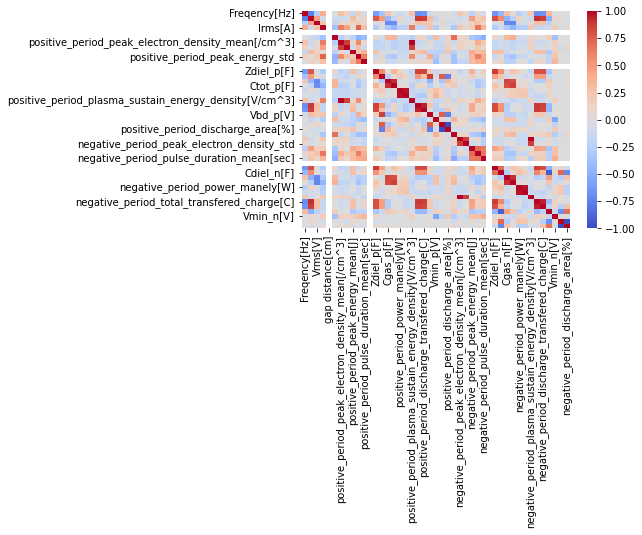

In [94]:
#상관관계분석
import seaborn as sb
sb.heatmap(plasma_data.corr(), cmap='coolwarm')

- 상관관계분석 결과를 보면 플라즈마 변수들이 서로 큰 상관관계가 없는 것을 알 수 있습니다.
- filamentary한 방전이 경우 각각의 전류펄스가 일종의 방전관처럼 서로 독립적이기 때문에 각각의 플라즈마 특성끼리 큰 관계가 없는것 같습니다.
- 변수들이 많아서 차원축소를 고려해봤지만 서로 상관관계가 크지 않은 변수들이 많아서 불필요하다고 생각합니다.

## 학습데이터와 테스트데이터 분리
- 학습데이터 80% 테스트데이터 20%로 설정합니다.
- 알고리즘별 학습결과를 비교하기 위해 random state를 0으로 설정합니다.


In [95]:
#학습데이터와 테스트데이터를 분리합니다
#학습데이터 80% 테스트데이터 20%로 설정합니다
#알고리즘별 학습결과를 비교하기 위해 random state를 0으로 설정합니다
X_train, X_test, y_train, y_test = train_test_split(plasma_data, plasma_label, test_size = 0.2, random_state=0)

## 모델평가 지표 : 정확도, 정밀도, 재현율, 오차행렬
- 표면손상데이터의 경우는 손상이후 데이터양이 부족하기 때문에 정확도만으로는 평가지표가 과도하게 높게 나올 수가 있습니다.
- 이를 보완하기 위해 정확도, 정밀도, 재현율, 오차행렬을 함께 제시합니다

In [96]:
#표면손상데이터의 경우는 손상이후 데이터양이 부족하기 때문에 정확도만으로는 평가지표가 부족할 수 있습니다.
#정확도, 정밀도, 재현율을 함께 제시합니다

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)*100
    precision = precision_score(y_test, pred, average='macro')*100
    recall = recall_score(y_test, pred, average='macro')*100
    
    print('오차행렬')
    print(confusion)
    print('정확도 :',"%.1f"%accuracy+'%')
    print('정밀도 :',"%.1f"%precision+'%')
    print('재현율 :', "%.1f"%recall+'%')

## 교차검증
- 과적합을 방지하기 위해 학습 데이터 셋을 다시 교차검증을 위해 나누어 학습을 진행합니다
- 각각의 나눠진 학습데이터에서 이뤄진 학습 결과를 비교해 최선의 학습모델을 선정합니다

In [97]:
def cross_score(model, X_train, y_train, cv):
  scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv)
  cross_val_accuracy_score = np.round(np.mean(scores),4) * 100
  print('교차 검증별 정확도 : ', np.round(scores,4))
  print('평균 검증 정확도 : ', "%.1f"%cross_val_accuracy_score +'%')

## 결정트리모델
- 결정트리모델을 이용해서 표면의 손상정도를 예측하는 머신러닝 모델입니다.
- 지니계수나 엔트로피를 이용해 데이터들이 모여있는 걸 기준(데이터 균일도)으로 분류를 하기 때문에 데이터 전처리가 거의 필요없다는 장점이 있습니다

In [98]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

In [99]:
get_clf_eval(y_test, dt_pred)

오차행렬
[[ 5  1  0]
 [ 1 17  0]
 [ 1  0  7]]
정확도 : 90.6%
정밀도 : 88.6%
재현율 : 88.4%


In [100]:
cross_score(dt_clf, X_train, y_train, 5)

교차 검증별 정확도 :  [0.7692 0.8462 0.6923 0.88   0.8   ]
평균 검증 정확도 :  79.8%


- GridSearch CV를 통해 최적의 하이퍼파라미터를 찾고 최적의 학습결과를 도출합니다.

In [101]:
parameters = {'max_depth':[2,3,5,10], 'min_samples_split':[2,3,5],  'min_samples_leaf':[1,5,8]}

grid_dt = GridSearchCV(dt_clf, param_grid = parameters, scoring='accuracy', cv=5)
grid_dt.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼파라미터 : ', grid_dt.best_params_)
best_score = grid_dt.best_score_ * 100
print('GridSearchCV 최고 정확도 :', "%.1f"%best_score+'%')
best_dt = grid_dt.best_estimator_

best_pred_dt = best_dt.predict(X_test)

GridSearchCV 최적 하이퍼파라미터 :  {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 84.4%


In [102]:
get_clf_eval(y_test, best_pred_dt)

오차행렬
[[ 5  1  0]
 [ 0 17  1]
 [ 0  0  8]]
정확도 : 93.8%
정밀도 : 94.4%
재현율 : 92.6%


In [103]:
cross_score(best_dt, X_train, y_train, 5)

교차 검증별 정확도 :  [0.7692 0.9231 0.8077 0.92   0.8   ]
평균 검증 정확도 :  84.4%


## 분류에 기준이 되는 주요 파라미터 분석 및 시각화



Vrms[V]                                             4.8e-01
Irms[A]                                             3.8e-01
Energy[J]                                           7.4e-02
negative_period_peak_electron_density_mean[/cm^3]   3.2e-02
Freqency[Hz]                                        2.9e-02
positive_period_peak_electron_density_std           4.9e-03
negative_period_power_manely[W]                     4.7e-03
Cdiel_n[F]                                          0.0e+00
negative_period_non_discharge_area[%]               0.0e+00
negative_period_peak_electron_density_std           0.0e+00
negative_period_peak_energy_mean[J]                 0.0e+00
negative_period_peak_energy_std                     0.0e+00
negative_period_pulse_duration_mean[sec]            0.0e+00
negative_period_pulse_duration_std                  0.0e+00
Zdiel_n[F]                                          0.0e+00
Vmin_n[V]                                           0.0e+00
Vbd_n[V]                                

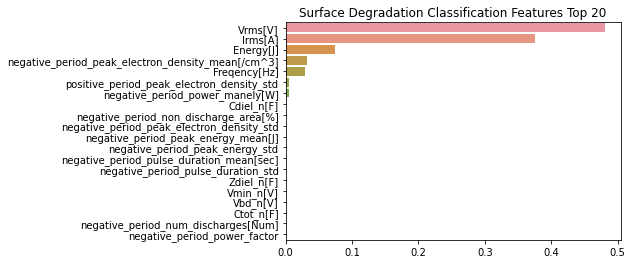

In [104]:
import seaborn as sns

importance_value = best_dt.feature_importances_
importance_value = pd.Series(importance_value, index=X_train.columns)
top20 = importance_value.sort_values(ascending=False)[:20]

plt.title('Surface Degradation Classification Features Top 20')
sns.barplot(x= top20, y=top20.index)
print(top20)

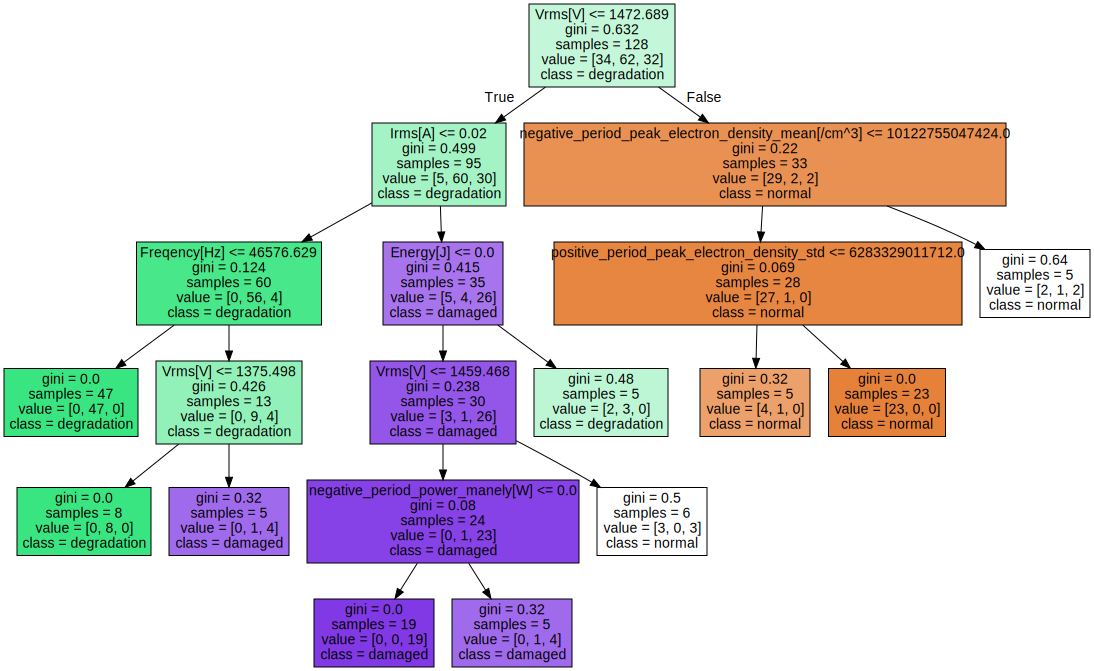

In [105]:
#graphviz를 이용한 결정트리모델을 시각화
from sklearn import tree
import graphviz

tree_dot = tree.export_graphviz(best_dt, feature_names = plasma_data.columns, class_names = ['normal', 'degradation', 'damaged'], filled= True)
dt_graph = graphviz.Source(tree_dot, format='png')
dt_graph

## 랜덤포레스트모델
- 결정트리와 동일한 분류 알고리즘을 이용합니다.
- 학습데이터를 여러개로 샘플링해서 다양한 학습세트로 학습을 할 수 있습니다
- 일종의 기출변형을 줘서 학습시킨 여러 분류기들을 이용해 최적의 학습결과를 만들어내는 모델이라고 생각할 수 있습니다.
- 하이퍼파라미터 튜닝을 통해 성능을 개선할 수 있습니다


In [106]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

In [107]:
get_clf_eval(y_test, rf_pred)

오차행렬
[[ 6  0  0]
 [ 0 17  1]
 [ 0  2  6]]
정확도 : 90.6%
정밀도 : 91.7%
재현율 : 89.8%


In [108]:
cross_score(rf_clf, X_train, y_train, 5)

교차 검증별 정확도 :  [0.8077 0.8846 0.8077 0.96   0.76  ]
평균 검증 정확도 :  84.4%


- GridSearch CV를 통해 최적의 하이퍼파라미터를 찾고 최적의 학습결과를 도출합니다.

In [109]:
parameters = {'max_depth':[2,3,5,10], 'min_samples_split':[2,3,5],  'min_samples_leaf':[1,5,8]}

grid_rf = GridSearchCV(rf_clf, param_grid = parameters, scoring='accuracy', cv=5)
grid_rf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼파라미터 : ', grid_rf.best_params_)
best_score = grid_rf.best_score_ * 100
print('GridSearchCV 최고 정확도 :', "%.1f"%best_score+'%')
best_rf = grid_rf.best_estimator_

best_pred_rf = best_rf.predict(X_test)

GridSearchCV 최적 하이퍼파라미터 :  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 84.4%


In [110]:
print("테스트세트에서의 평가지표")
get_clf_eval(y_test, best_pred_rf)

테스트세트에서의 평가지표
오차행렬
[[ 6  0  0]
 [ 0 17  1]
 [ 0  2  6]]
정확도 : 90.6%
정밀도 : 91.7%
재현율 : 89.8%


In [111]:
cross_score(best_rf, X_train, y_train, 5)

교차 검증별 정확도 :  [0.8077 0.8846 0.8077 0.96   0.76  ]
평균 검증 정확도 :  84.4%


## 분류에 기준이 되는 주요 파라미터분석 및 시각화

Vrms[V]                                                 2.1e-01
Irms[A]                                                 1.3e-01
Energy[J]                                               9.0e-02
Freqency[Hz]                                            6.4e-02
positive_period_peak_electron_density_mean[/cm^3]       4.1e-02
Vbd_n[V]                                                3.8e-02
Vbd_p[V]                                                3.5e-02
negative_period_peak_electron_density_mean[/cm^3]       3.2e-02
positive_period_plasma_sustain_energy_density[V/cm^3]   3.1e-02
positive_period_peak_energy_std                         3.0e-02
negative_period_plasma_sustain_energy_density[V/cm^3]   2.5e-02
positive_period_power_factor                            2.2e-02
negative_period_peak_electron_density_std               2.2e-02
positive_period_power_manely[W]                         2.1e-02
negative_period_power_manely[W]                         2.1e-02
positive_period_num_discharges[Num]     

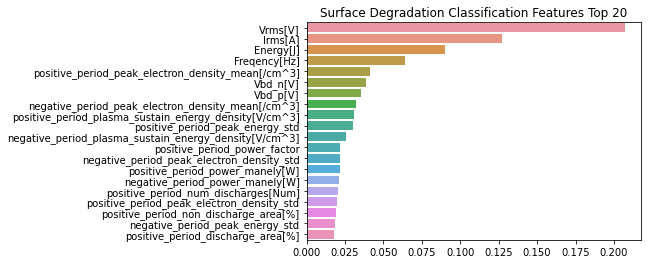

In [112]:
import seaborn as sns

importance_value = best_rf.feature_importances_
importance_value = pd.Series(importance_value, index=X_train.columns)
top20 = importance_value.sort_values(ascending=False)[:20]

plt.title('Surface Degradation Classification Features Top 20')
sns.barplot(x= top20, y=top20.index)
print(top20)

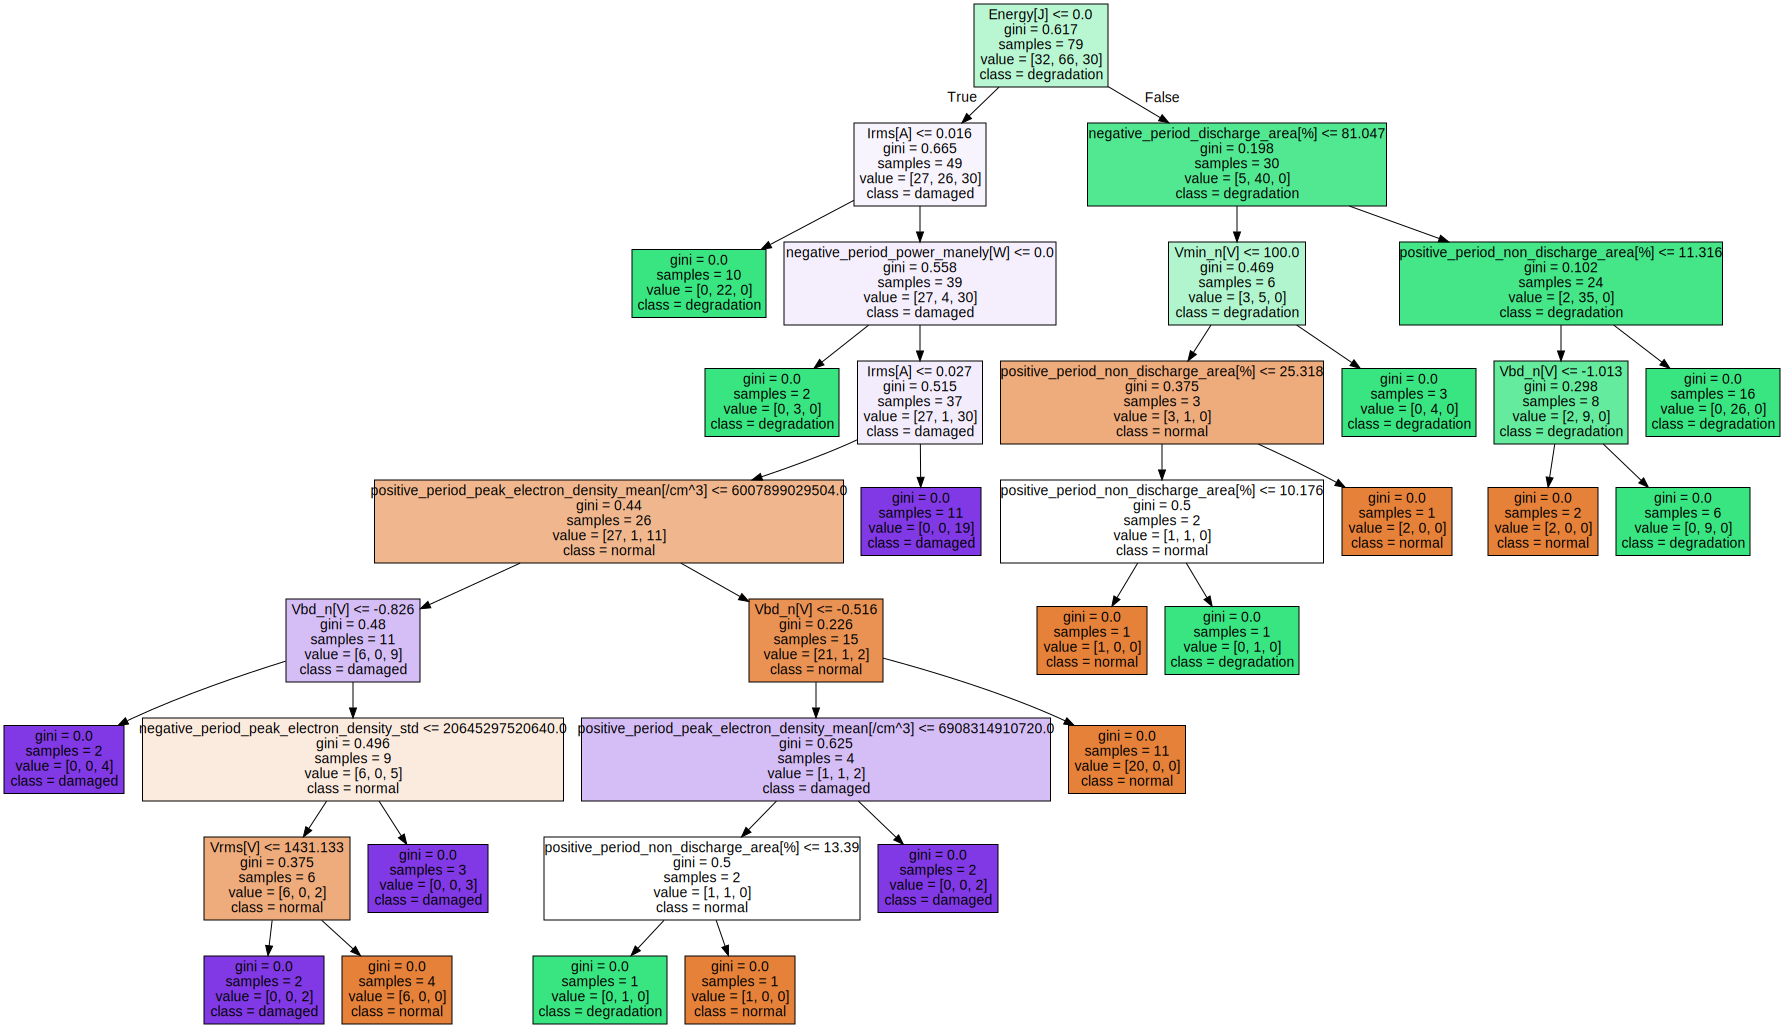

In [113]:
from sklearn import tree
import graphviz

best_clf = best_rf[3]
tree_dot = tree.export_graphviz(best_clf, feature_names = plasma_data.columns, class_names = ['normal', 'degradation', 'damaged'], filled= True)
dt_graph = graphviz.Source(tree_dot, format='png')
dt_graph

# 학습된 모델을 이용한 플라즈마 방전기의 표면변화 예측
- 새롭게 실험한 데이터셋 전체를 테스트데이터로 사용하여 만들어진 모델이 표면을 잘 진단하는지 시험해봅니다.


In [115]:
path = '/content/drive/MyDrive/Colab Notebooks/[개인프로젝트]플라즈마표면진단ML DL/data'
os.chdir(path)
df1 = pd.read_csv("m1_data_final.csv", encoding='utf-8-sig', error_bad_lines=False)

In [116]:
plasma_label1 = df1['Surface_degradation']
plasma_data1 = df1.drop(['Surface_degradation','Measured Date'], axis=1)

In [117]:
X_test1 = plasma_data1
y_test1 = plasma_label1

In [118]:
#랜덤포레스트 모델을 이용한 분류예측
best_pred1 = best_rf.predict(X_test1)
print("테스트세트에서의 평가지표")
get_clf_eval(y_test1, best_pred1)

테스트세트에서의 평가지표
오차행렬
[[38  0  2]
 [ 0 20  0]
 [ 2 28 10]]
정확도 : 68.0%
정밀도 : 73.3%
재현율 : 73.3%


In [119]:
#결정트리 모델을 이용한 분류예측
best_pred2 = best_dt.predict(X_test1)
print("테스트세트에서의 평가지표")
get_clf_eval(y_test1, best_pred2)

테스트세트에서의 평가지표
오차행렬
[[38  2  0]
 [ 0 20  0]
 [ 2  8 30]]
정확도 : 88.0%
정밀도 : 87.2%
재현율 : 90.0%


- 새롭게 실험한 플라즈마 측정데이터에서 분류정확도가 68% ~ 88% 정도가 나왔습니다.
- 랜덤포레스트의 하이퍼파라미터를 잘 정의하지 못해서 결정트리보다 정확도가 더 낮게 나온 것 같습니다.
- 시계열 분석을 통해 시간에 따른 데이터의 변화를 추적하면 더 좋은 성능의 분류기를 만들 수 있을 것 같습니다.
